# MRS_Voxel-to-Voxel

Prefixes:
=========
-) BETA_ nii the BETA files contain the Fisher transformed coefficients ( z=atanh(r) ). When the Analyses.measure is set to 3 (regression) or 4 (multivariate regression), then the BETA files contain the regression coefficients (beta values) and the corr files should be disregarded (they actually contain tanh(beta) but these are not particularly meaningful measures). 

-) corr_ nii When the Analyses.measure field is set to 1 (bivariate correlation) or 2 (semi-partial correlation) the corr fles contain the correlation coefficients (r) (or semi-partial correlation coefficients when Analyses.measure is set to 2)..... corr_* files are only generated if you select the corresponding option in the Setup->Options tab ('Create first-level seed-to-voxel r-maps').

-) p_corr nii the p_corr and pFDR images simply contain the uncorrected and FDR-corrected p-values, respectively

-) pFDR nii the p_corr and pFDR images simply contain the uncorrected and FDR-corrected p-values, respectively

-) resultsROI mat

-) se nii
-) 

## Sources

In [1]:
import glob
import nibabel as nib
import pandas as pd
import seaborn as sns
from nilearn import plotting
import numpy as np
from scipy.io import loadmat
from scipy import stats
import multiprocess as mp

In [2]:
mat = loadmat('/media/veracrypt1/NeuroMet_fmri_2/MRS_Voxel_to_Voxel/_list_sources.mat')

In [3]:
mat['sourcenames']

array([[array(['MRS_Voxel'], dtype='<U9'),
        array(['MRS_Voxel_MNI2009'], dtype='<U17')]], dtype=object)

In [4]:
# MRS Voxel is source 2

In [5]:
# Grab all MRS-Voxel-to-whole-Brain connectivity maps niftis
s1_beta_path = glob.glob('/media/veracrypt1/NeuroMet_fmri_2/MRS_Voxel_to_Voxel/BETA_Subject0*_Condition001_Source002.nii')
len(s1_beta_path)

95

In [6]:
example_img = nib.load(s1_beta_path[0])

In [7]:
subnumber = len(s1_beta_path)

In [8]:
# sort them
s1_beta_path = sorted(s1_beta_path, key=(lambda x: x.split('_')[-3][-3:]))

### thresholding to 0.3 every image (corresponding p ~ 0.01)

In [9]:
%%time
def threshold_conn_map(conn_map, threshold = 0.3, subnum = 0):
    return (subnum, np.where(conn_map>threshold,conn_map,0))

threshold = 0.3
conns_thrs = list(range(subnumber)) # initialize conn list

p = mp.Pool(processes = 4)
for n in range(subnumber):
    conn_map = nib.load(s1_beta_path[n]).get_fdata()
    res = p.apply_async(threshold_conn_map, (conn_map, threshold, n)).get()
    conns_thrs[res[0]] = res[1]
    #print('{}: done'.format(res[0]))

CPU times: user 18.1 s, sys: 53.1 s, total: 1min 11s
Wall time: 3min 41s


In [ ]:
conns_thrs[0].shape

In [ ]:
%%time
# Plot a thresholded conn_map
i = conns_thrs[34]
plotting.plot_stat_map(nib.Nifti1Image(i, example_img.affine, header=example_img.header), cut_coords=(0,42,22))

In [ ]:
#np.savez('./conns_thresholded03.npz', conns_thrs=conns_thrs)
np.save('./conns_thresholded03.np', conns_thrs)

In [ ]:
#conns_thrs = np.load('./conns_thresholded03.npz')['conns_thrs']

In [ ]:
conns_thrs.shape

In [ ]:
# GM Mask

In [10]:
gm = nib.load('/home/orco/Dokumente/Charitè/MNITemplate/inst/extdata/MNI152_T1_1mm_Brain_FAST_seg.nii.gz')

In [11]:
gm_mask = gm.get_fdata()
gm_mask = np.where(gm_mask==2, gm_mask,0)

In [12]:
gm = nib.Nifti1Image(gm_mask, gm.affine, header=gm.header)

In [13]:
from nilearn import image
gm = image.resample_img(gm, target_affine=example_img.affine, target_shape=conns_thrs[0].shape)

In [14]:
# Grey Matter mask
gm_mask = gm.get_fdata()
gm_mask = np.where(gm_mask>0,1,0)

In [15]:
gm = nib.Nifti1Image(gm_mask, example_img.affine, header=example_img.header)

In [16]:
nib.save(gm,'gm.nii.gz')

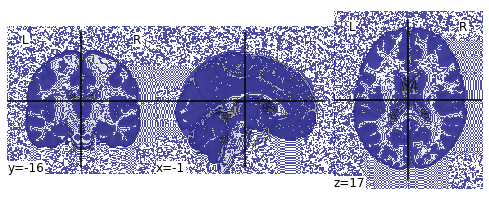

In [17]:
plotting.plot_roi(gm)

In [18]:
# Apply GM Mask and calculate average

In [19]:
%%time    
def avg_conn(conns_thrs, gm_mask, subnum):
    conn_thrs_gm = conns_thrs * gm_mask
    return (subnum, conn_thrs_gm.sum()/conn_thrs_gm.astype(bool).sum())

avg_conns = list(range(subnumber)) # initialize conn list

p = mp.Pool(processes = 4)
for subnum in range(subnumber):
    res = p.apply_async(avg_conn,(conns_thrs[subnum], gm_mask, subnum)).get()
    #res = p.apply_async(avg_conn,(conns_thrs.pop(), gm_mask, subnum)).get()
    avg_conns[res[0]] = res[1]

CPU times: user 11.9 s, sys: 25.5 s, total: 37.5 s
Wall time: 2min


In [20]:
# Load data

In [21]:
data = pd.read_csv('/home/orco/Dokumente/Charitè/GSH_fMRI/data/data_spheres.csv')

In [22]:
data.head()

,NeuroMET_num,ID_l,diag,QC,pcc_dmn_sph,pcc_pcc_sph,pcc_mpfc_sph,pcc_lipl_sph,pcc_ripl_sph,mpfc_mpfc_sph,mpfc_lipl_sph,mpfc_ripl_sph,lipl_lipl_sph,lipl_ripl_sph,ripl_ripl_sph,CONN_ID,ID,GSH,GSH_CRLBp,Age
0,3,sub-NeuroMET003,2.0,G,1.049036,NaN,0.343069,0.899379,0.924406,NaN,0.230542,0.053121,NaN,0.765054,NaN,1,NeuroMet003,1.09,0.09,79
1,4,sub-NeuroMET004,0.0,G,1.750689,NaN,0.993763,1.508367,1.723746,NaN,0.951099,0.993852,NaN,1.557998,NaN,2,NeuroMet004,0.93,0.11,72
2,6,sub-NeuroMET006,0.0,G,1.016192,NaN,0.316543,1.024255,1.047236,NaN,0.180779,0.381759,NaN,0.734609,NaN,3,NeuroMet006,1.24,0.12,74
3,7,sub-NeuroMET007,1.0,G,1.017692,NaN,0.455403,0.817241,0.818532,NaN,0.312894,0.246930,NaN,0.804161,NaN,4,NeuroMet007,0.94,0.12,69
4,8,sub-NeuroMET008,0.0,G,0.994304,NaN,0.857699,0.639962,0.776978,NaN,0.336502,0.629242,NaN,0.537692,NaN,5,NeuroMet008,1.58,0.13,68


In [23]:
data['mrs_to_voxel_thr03_masked_gm'] = avg_conns

In [25]:
data.to_csv('../data/data_all_fcs.csv')

<AxesSubplot:xlabel='diag', ylabel='mrs_to_voxel_thr03_masked_gm'>

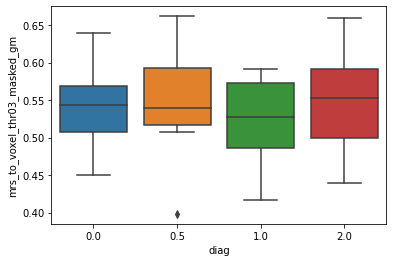

In [24]:
sns.boxplot(x='diag', y='mrs_to_voxel_thr03_masked_gm', data=data)

In [ ]:
stats.f_oneway(data[(data.diag2=='0')].mrs_to_voxel_thr03_masked_gm.values,
              data[(data.diag2=='0,5')].mrs_to_voxel_thr03_masked_gm.values,
              data[(data.diag2=='1')].mrs_to_voxel_thr03_masked_gm.values,
              data[(data.diag2=='2')].mrs_to_voxel_thr03_masked_gm.values)

In [ ]:
sns.scatterplot(x='GSH', y='mrs_to_voxel_thr03_masked_gm', hue='diag', data=data)

In [ ]:
stats.pearsonr(data.GSH_All.values, data.mrs_to_voxel_thr03_masked_gm.values)

In [ ]:
sns.scatterplot(x='pcc_dmn_sph', y='mrs_to_voxel_thr03_masked_gm', hue='diag', data=data)

In [ ]:
stats.pearsonr(data.pcc2dmn_gm.values, data.mrs_to_voxel_thr03_masked_gm.values)